#### Part 1: Data Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Importing the dataset
cwd = Path.cwd() / "datasets"
dataset = pd.read_csv(os.path.join(cwd, 'Churn_Modelling.csv'))
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

In [3]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

categorical_columns = [1, 2]
# One-hot encode categorical columns using ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)
X = column_transformer.fit_transform(X)

In [4]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Print the sizes of the sets
print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Validation set size:", X_val.shape[0])

Train set size: 8000
Test set size: 1000
Validation set size: 1000


In [5]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

#### Part 2 - making the ANN!

In [6]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=X_train.shape[1]))

# Adding the second hidden layer
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

# Adding the output layer
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compiling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         batch_size=10,
                         epochs=100)

Epoch 1/100
800/800 [==============================] - 4s 3ms/step - loss: 0.4765 - accuracy: 0.7960 - val_loss: 0.4291 - val_accuracy: 0.7920
Epoch 2/100
800/800 [==============================] - 3s 3ms/step - loss: 0.4295 - accuracy: 0.7960 - val_loss: 0.4220 - val_accuracy: 0.7920
Epoch 3/100
800/800 [==============================] - 3s 4ms/step - loss: 0.4246 - accuracy: 0.7960 - val_loss: 0.4156 - val_accuracy: 0.7920
Epoch 4/100
800/800 [==============================] - 3s 4ms/step - loss: 0.4193 - accuracy: 0.8196 - val_loss: 0.4120 - val_accuracy: 0.8200
Epoch 5/100
800/800 [==============================] - 3s 3ms/step - loss: 0.4164 - accuracy: 0.8264 - val_loss: 0.4121 - val_accuracy: 0.8340
Epoch 6/100
800/800 [==============================] - 3s 3ms/step - loss: 0.4146 - accuracy: 0.8266 - val_loss: 0.4089 - val_accuracy: 0.8370
Epoch 7/100
800/800 [==============================] - 2s 3ms/step - loss: 0.4124 - accuracy: 0.8294 - val_loss: 0.4079 - val_accuracy: 0.8330

Visualising the training

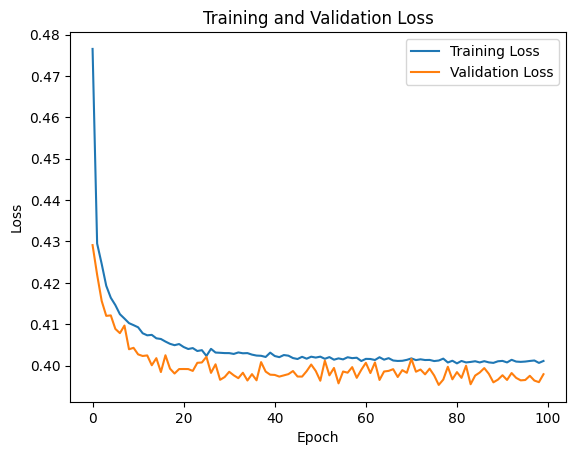

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Part 3 - Making the predictions and evaluating the model

In [8]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

32/32 [==============================] - 0s 2ms/step


array([[769,  34],
       [127,  70]])

In [9]:
# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 83.90%
Precision: 0.67
Recall: 0.36
F1 Score: 0.47


In [10]:
# Create a classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       803
           1       0.67      0.36      0.47       197

    accuracy                           0.84      1000
   macro avg       0.77      0.66      0.69      1000
weighted avg       0.82      0.84      0.82      1000



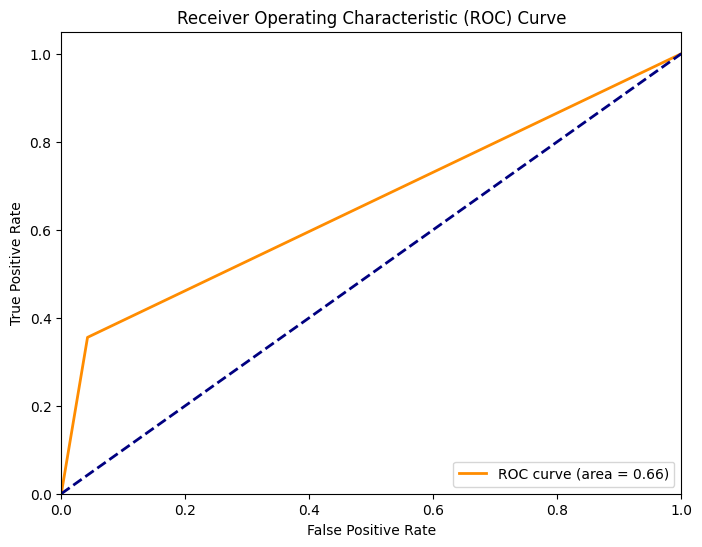

In [11]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()